In [5]:
import numpy as np
from ss_problem import SSProblem, SecureStateReconstruct
from tests import generate_random_dtsystem_data, generate_random_io_data,solve_ssr_by_decomposition
from safe_control import LinearInequalityConstr
from scipy import linalg

n = 8
m = 3
p = 5
s = 2

seed = 100
rng = np.random.default_rng(seed=seed)

# define system
dtsys_a, dtsys_b, dtsys_c, dtsys_d = generate_random_dtsystem_data(rng,n,m,p)

# define true and fake initial states
init_state1 = rng.normal(10,2,(n,1))
init_state2 = 2*init_state1
sensor_initial_states = [init_state2 if i < s else init_state1 for i in range(p)]

# define io data
u_seq, tilde_y_his, noise_level = generate_random_io_data(dtsys_a,dtsys_b, dtsys_c, dtsys_d, s, sensor_initial_states, 
                            rng, has_u_seq = False, is_noisy = False)

# construct a problem instance and a solution instance
ss_problem = SSProblem(dtsys_a, dtsys_b, dtsys_c, dtsys_d, tilde_y_his, 
                        attack_sensor_count=s,input_sequence=u_seq,measurement_noise_level= noise_level )
# ssr_solution = SecureStateReconstruct(ss_problem,possible_comb=comb1)
ssr_solution = SecureStateReconstruct(ss_problem)

# solve for sparse observability index (soi) and eigenvalue observability index (eoi) 
soi = SecureStateReconstruct.compute_sparse_observability(ss_problem.A,ss_problem.C)
eoi = SecureStateReconstruct.compute_eigenvalue_observability(ss_problem.A,ss_problem.C)
print(f'The problem have a sparse observability index {soi}, eigenvalue observability index: {eoi}, attacked sensor count: {s}')

# solve ssr by brute-force approach
possible_states_bruteforce,corresp_sensors, _ = ssr_solution.solve_initial_state(error_bound = 1e-3)

# solve ssr by decomposition
possible_states_decomposition = solve_ssr_by_decomposition(ssr_solution, eoi)

# printing
for full_state in possible_states_bruteforce.transpose():
    print('-----------------------  brute-force   approach  -------------------------------')
    if np.linalg.norm(full_state.reshape(-1,1)-init_state1)<1e-3:
        print(f'Initial state 1 is a plausible state based on SSR by brute-force approach')
    if np.linalg.norm(full_state.reshape(-1,1)-init_state2)<1e-3:
        print(f'Initial state 2 is a plausible state based on SSR by brute-force approach')

for full_state in possible_states_decomposition:
    print('-----------------------  decomposition approach  -------------------------------')
    if np.linalg.norm(full_state.reshape(-1,1)-init_state1)<1e-3:
        print(f'Initial state 1 is a plausible state based on SSR by decomposition approach')
    if np.linalg.norm(full_state.reshape(-1,1)-init_state2)<1e-3:
        print(f'Initial state 2 is a plausible state based on SSR by decomposition approach')


The problem have a sparse observability index 4, eigenvalue observability index: 4, attacked sensor count: 2
-----------------------  brute-force   approach  -------------------------------
Initial state 1 is a plausible state based on SSR by brute-force approach
-----------------------  decomposition approach  -------------------------------
Initial state 1 is a plausible state based on SSR by decomposition approach


The problem have a sparse observability index 6, eigenvalue observability index: 7, attacked sensor count: 4
execution time by subspace decomposition: 12.165719459990214 ms
execution time by brute-force approach:   2.1943779900175286 ms
-----------------------  decomposition approach  -------------------------------
Initial state 2 is a plausible state based on SSR by decomposition approach
-----------------------  decomposition approach  -------------------------------
Initial state 1 is a plausible state based on SSR by decomposition approach
-----------------------  brute-force   approach  -------------------------------
Initial state 2 is a plausible state based on SSR by brute-force approach
-----------------------  brute-force   approach  -------------------------------
Initial state 1 is a plausible state based on SSR by brute-force approach
The problem have a sparse observability index 7, eigenvalue observability index: 7, attacked sensor count: 4
The problem have a sparse obse

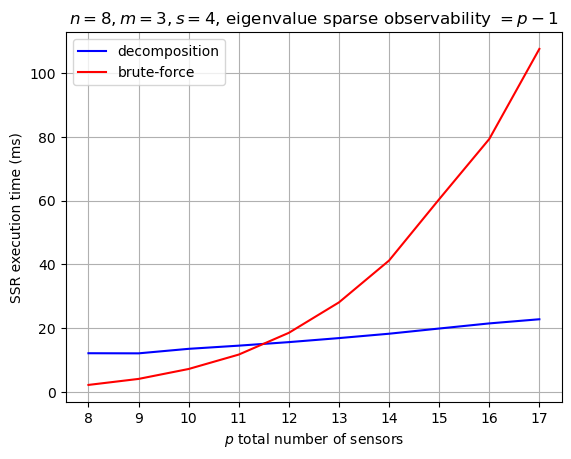

The problem have a sparse observability index 6, eigenvalue observability index: 6, attacked sensor count: 4
u_safe with efficient algorithm: [0.12348741 0.63284493 0.16884151 0.53921033]
True
True
True
True
True
True
True


In [7]:
from tests import main_ssr,main_ssr_timing,main_secure_and_safe_control
main_ssr()
main_ssr_timing()
main_secure_and_safe_control()

In [3]:
import numpy as np
from cvxopt import matrix
from safe_control import LinearInequalityConstr

EPS = 1e-5
a = [[1,2,3],[4,5,6]]

a_mat = np.array(a)
b_vec = np.array([[1],[2]])

lic = LinearInequalityConstr(a_mat,b_vec)
u = np.array([[1],[2],[2.1]])

print(a_mat@u + b_vec)
lic.is_satisfy(u)




[[12.3]
 [28.6]]


True

In [ ]:
import numpy as np
from ss_problem import SSProblem, SecureStateReconstruct
from scipy import linalg
import numpy as np

np.random.seed(100)
TS = 0.05
s  = 0
Ac = np.matrix(
                [
                    # [0, 0, 1, 0],
                    # [0, 0, 0, 1],
                    # [0, 0, 0, 0],
                    # [0, 0, 0, 0]
                    [0, 1],  # x xdot
                    [0, 0],
                ])
Bc = np.matrix(
                [
                    # [0, 0],
                    # [0, 0],
                    # [1, 0],
                    # [0, 1]
                    [1],
                    [0],
                ]
            )
Cc = np.matrix(
                [
                    # [1, 0, 0, 0],
                    # [1, 0, 0, 0],
                    # [0, 1, 0, 0],
                    # [0, 1, 0, 0],
                    # [0, 0, 1, 0],
                    # [0, 0, 1, 0],
                    # [0, 0, 0, 1],
                    # [0, 0, 0, 1],
                    [1, 0],  # x1 xdot1 x2 xdot2
                    [0, 1],
                    [1, 0],
                    [0, 1],
                ]
            )

Dc = np.matrix(
                [
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0]
                    [0],
                    [0],
                    [0],
                    [0],
                ]
            )

dtsys_a, dtsys_b, dtsys_c, dtsys_d = SSProblem.convert_ct_to_dt(Ac,Bc,Cc,Dc,TS)
# define input output data
init_state1 = np.array([[1.],[2.]])
# u_seq = np.array([[1,1],[1,1],[1,1],[0,0]])
# assume sensors 1,3,5 are under attack
sensor_initial_states = [init_state1,init_state1,init_state1,init_state1]
u_seq, tilde_y_his, noise_level = SSProblem.generate_attack_measurement(dtsys_a, dtsys_b, dtsys_c, dtsys_d,sensor_initial_states,
                                                                        s = s,is_noisy = False, noise_level=0.001,u_seq = None)
# u_seq = np.random.normal(3,2.5,size=(2,1))
# tilde_y_his = np.random.normal(10,4,size=(2,4))

noise_level=0.001
ss_problem = SSProblem(dtsys_a, dtsys_b, dtsys_c, dtsys_d, tilde_y_his, 
                        attack_sensor_count=s,input_sequence=u_seq,measurement_noise_level= noise_level )
ssr_solution = SecureStateReconstruct(ss_problem)
possible_initial_states,corresp_sensors, _ = ssr_solution.solve_initial_state(error_bound = 1000)

possible_states,corresp_sensors, _ = ssr_solution.solve(error_bound = 1000)
print(f'u_seq:{u_seq}')
print(f'tilde_y_his: {tilde_y_his}')
print(f'possible_initial states: {possible_initial_states}')
print(f'possible states: {possible_states}')



In [ ]:
print('-------------------------------------')
self = ss_problem
print(f'dtsys_a: {ss_problem.A}, \n dtsys_b: {self.B}, \n dtsys_c:{self.C} ')
print(f'output_sequence:{self.tilde_y_his}')
print(f'input_sequence:{self.u_seq}')
print(f'observation matrix: {ssr_solution.obser[:,:,0]}')
print(f'observation matrix: {ssr_solution.obser[:,:,1]}')
print(f'clean output sequence" {ssr_solution.y_his}')
print(f'estimated state: {possible_states}')

print()

In [ ]:
import numpy as np
from ss_problem import SSProblem, SecureStateReconstruct
from scipy import linalg
import control as ct

# def to_test_code():
# randomize system to test 
init_state1 = np.array([[1.],[1.],[1.],[1.]])
dtsys_a = np.array( [[ 7.09221296,  4.50145174,  6.45752449,  3.09727833],
 [ 6.9494097,   3.62746914,  3.57307166, -0.82619306],
 [11.04056775,  3.08802872,  3.86302024,  5.47661976],
 [ 5.27031611,  5.20731065,  2.81388349, -4.12382917]])
dtsys_c = np.random.normal(1,1,size=[8,4]) # if given enough sensor redundancy

eig_vals,eig_vecs = linalg.eig(dtsys_a)
I0 = np.eye(dtsys_a.shape[0])
# while(not all(np.isreal(eig_vals))):
#     dtsys_a = np.random.normal(3,3,size=[4,4])
#     eig_vals = linalg.eigvals(dtsys_a)
print(f'eig_vals: {eig_vals}')

eigenspaces = [eig_vecs[:,i:i+1] for i in range(eig_vecs.shape[1])]
r = len(eigenspaces)
# print(eigenspaces)
# print(f'test eigenvector: {linalg.norm((dtsys_a- eig_vals[0]*I0)@eigenspaces[0])}')

projections = []
x_components = []
for j in range(r):
    proj = SecureStateReconstruct.construct_proj(eigenspaces,j)
    xcomponent = proj@init_state1
    x_components.append(xcomponent)
    projections.append(proj)

x_recover  = np.sum(x_components,axis=0)
print(f'x:{init_state1}, x components: {x_components}, recovered: {x_recover}')


In [ ]:
for i in range(dtsys_c.shape[0]):
    obsrv_spaces_i = []
    obsrv_projs_i = []
    Ci = dtsys_c[i:i+1,:]
    obsrv_matrix = ct.obsv(dtsys_a,Ci)
    Yi = obsrv_matrix@init_state1
    for j in range(r):
        obsrv_space_ij = obsrv_matrix@eigenspaces[j]
        obsrv_spaces_i.append(obsrv_space_ij)
    
    Y_i_list = []
    for j in range(r):
        proj_obsrv_ij = SecureStateReconstruct.construct_proj(obsrv_spaces_i,j)
        Y_ij = proj_obsrv_ij@Yi
        obsrv_projs_i.append(proj_obsrv_ij)
        Y_i_list.append(Y_ij)
    Y_ij_sum = np.sum(Y_i_list,axis= 0)
    print(f'{i}th sensor, Yi - Y_ij_sum is {linalg.norm(Yi- Y_ij_sum)}')

    # solve for state for subssr problems
    x_recovered_list = []
    for j in range(r):
        Aj = projections[j]@dtsys_a
        observ_matrix = ct.obsv(Aj,Ci)
        # x_j = linalg.pinv(observ_matrix)@Y_i_list[j]
        x_j, residuals = SecureStateReconstruct.solve_lstsq_from_subspace(observ_matrix,Y_i_list[j],eigenspaces[j]) # rank defficient, not accurate
        print(f'residuals: {residuals}')
        x_j = x_j.reshape(-1,1)
        x_recovered_list.append(x_j)

        # print(f'j = {j}, the difference btw x_components[j] and x_j is {linalg.norm(x_components[j]- x_j)}')
        err = linalg.norm(observ_matrix@x_components[j] - Y_i_list[j])
        # print(f'x_j {x_j.T}, x_components[j] {x_components[j].T}')
        # print(f'j = {j}, the error bound is {err}')
    print(f'The sum of recovered states is {np.sum(x_recovered_list,axis=0).T}')


    


In [ ]:
import timeit

execution_time = timeit.timeit(to_test_code, number=1000)

print(f'execution time {execution_time}s')

In [ ]:
from scipy import linalg
Ac = np.random.normal(3,3,size=[4,4])
eig_vals = linalg.eigvals(Ac)
i = 0
while(not all(np.isreal(eig_vals))):
    Ac = np.random.normal(3,3,size=[4,4])
    eig_vals = linalg.eigvals(Ac)
    i = i+1
    print(i)

print(f'eig_vals: {eig_vals}')

In [ ]:
dtsys_a = np.array( [[ 7.09221296,  4.50145174,  6.45752449,  3.09727833],
 [ 6.9494097,   3.62746914,  3.57307166, -0.82619306],
 [11.04056775,  3.08802872,  3.86302024,  5.47661976],
 [ 5.27031611,  5.20731065,  2.81388349, -4.12382917]])

unique_eigvals, generalized_eigenspace_list, am_list, gm_list = SecureStateReconstruct.compute_sys_eigenproperty(dtsys_a)
print(f'gm_list: {gm_list}')
print(f'unique_eigvals:{unique_eigvals}')
print(f'generalized_eigenspace_list:{generalized_eigenspace_list}')

In [ ]:
from scipy import linalg
eigval, eigvec = linalg.eig(dtsys_a)


In [ ]:
a = np.array(range(24))
a = a.reshape(-1,2)
print(f'a before unvstack: {a}')
io_len = 4
a_prime = SecureStateReconstruct.unvstack(a,io_len)

print(f'a after unvstack: {a_prime[:,:,2]}')

a_colum_list = [a_prime[:,i:i+1] for i in range(a_prime.shape[1])]
a_v = np.vstack(a_colum_list)
print(f'a after unvstack then vstack: {a_v}')


In [ ]:
dtsys_a = np.random.normal(3,3,size=[4,4])
b = dtsys_a@np.array([[1],[1],[1],[1]])
b.shape

In [ ]:
I = np.eye(dtsys_a.shape[0])
nullspace = linalg.null_space(dtsys_a - eigval[0]*I)
linalg.norm((dtsys_a - eigval[0]*I)@eigvec[:,0])
print(f'nullspace:{nullspace}')

In [ ]:
import numpy as np
from mpmath import mp, mpf, matrix, eig

# Set precision (e.g., 50 decimal places)
mp.dps = 50

def compute_high_precision_eigenspaces(matrix_A):
    # Convert matrix to mpmath matrix with higher precision
    mp_matrix = matrix([list(map(mpf, row)) for row in matrix_A])
    
    # Compute eigenvalues and eigenvectors using mpmath
    eigenvalues, eigenvectors = eig(mp_matrix)
    
    eigenspaces = {}
    
    for i, eigenvalue in enumerate(eigenvalues):
        eigenvector = eigenvectors[:, i]
        
        # Normalize the eigenvector
        norm = mp.sqrt(sum(x**2 for x in eigenvector))
        eigenvector = eigenvector / norm
        
        # Convert back to numpy arrays for convenience
        eigenspaces[float(eigenvalue)] = np.array([float(x) for x in eigenvector])
    
    return eigenspaces

# Example matrix
A = np.array([[4, -2],
              [1, 1]], dtype=float)

eigenspaces = compute_high_precision_eigenspaces(A)

for eigenvalue, eigenvector in eigenspaces.items():
    print(f"Eigenvalue: {eigenvalue}")
    print(f"Eigenvector: {eigenvector}\n")


In [ ]:
import numpy as np
from scipy import linalg

dtsys_a = np.array( [[ 7.09221296,  4.50145174,  6.45752449,  3.09727833],
 [ 6.9494097,   3.62746914,  3.57307166, -0.82619306],
 [11.04056775,  3.08802872,  3.86302024,  5.47661976],
 [ 5.27031611,  5.20731065,  2.81388349, -4.12382917]])

eigval, eigvec = linalg.eig(dtsys_a)
I = np.eye(dtsys_a.shape[0])

A = dtsys_a - eigval[0]*I
nullspace = linalg.null_space(A,rcond=1e-10)


u, s, vh = linalg.svd(A, full_matrices=True)
M, N = u.shape[0], vh.shape[1]
rcond = np.finfo(s.dtype).eps * max(M, N)
tol = np.amax(s, initial=0.) * rcond
num = np.sum(s > tol, dtype=int)
# num = 2
Q = vh[num:,:].T.conj()
print(f'tol is {tol}, s is {s}, nullspace is {nullspace}, Q is {Q}')

In [ ]:
vh

In [ ]:
%timeit possible_states,corresp_sensors, _ = ssr_solution.solve(error_bound = 1e-2)


In [ ]:
if possible_states is not None:
    for ind in range(corresp_sensors.shape[0]):
        sensors = corresp_sensors[ind,:]
        state = possible_states[:,ind]
        print(f'Identified possible states:{state} for sensors {sensors}')

In [ ]:
import timeit

execution_time = timeit.timeit(lambda: ssr_solution.solve(error_bound = 1e-2), number=100)

print(execution_time)


In [ ]:
att_dic

In [ ]:
print(np.finfo(np.double).precision)

In [ ]:
residuals_list = [1,2,3,4]
residual_min = min(residuals_list)
comb_list = residual_min<2*residual_min

In [ ]:
residuals_list[0]

In [ ]:
import numpy as np
from ss_problem import SSProblem, SecureStateReconstruct
from scipy import linalg
import numpy as np

TS = 0.02
s  = 0
Ac = np.matrix(
                [
                    # [0, 0, 1, 0],
                    # [0, 0, 0, 1],
                    # [0, 0, 0, 0],
                    # [0, 0, 0, 0]
                    [0, 1],  # x xdot
                    [0, 0],
                ])
Bc = np.matrix(
                [
                    # [0, 0],
                    # [0, 0],
                    # [1, 0],
                    # [0, 1]
                    [0],
                    [1],
                ]
            )
Cc = np.matrix(
                [
                    # [1, 0, 0, 0],
                    # [1, 0, 0, 0],
                    # [0, 1, 0, 0],
                    # [0, 1, 0, 0],
                    # [0, 0, 1, 0],
                    # [0, 0, 1, 0],
                    # [0, 0, 0, 1],
                    # [0, 0, 0, 1],
                    [1, 0],  # x1 xdot1 x2 xdot2
                    [0, 1],
                    [1, 0],
                    [0, 1],
                ]
            )

Dc = np.matrix(
                [
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0],
                    # [0, 0]
                    [0],
                    [0],
                    [0],
                    [0],
                ]
            )

dtsys_a, dtsys_b, dtsys_c, dtsys_d = SSProblem.convert_ct_to_dt(Ac,Bc,Cc,Dc,TS)
# define input output data
init_state1 = np.array([[1.],[2.]])
# u_seq = np.array([[1,1],[1,1],[1,1],[0,0]])
# assume sensors 1,3,5 are under attack
sensor_initial_states = [init_state1,init_state1,init_state1,init_state1]
# u_seq, tilde_y_his, noise_level = SSProblem.generate_attack_measurement(dtsys_a, dtsys_b, dtsys_c, dtsys_d,sensor_initial_states,
#                                                                         s = s,is_noisy = False, noise_level=0.001,u_seq = None)
u_seq = np.random.normal(3,2.5,size=(2,1))
tilde_y_his = np.random.normal(10,4,size=(2,4))

noise_level=0.001
ss_problem = SSProblem(dtsys_a, dtsys_b, dtsys_c, dtsys_d, tilde_y_his, 
                        attack_sensor_count=s,input_sequence=u_seq,measurement_noise_level= noise_level )
ssr_solution = SecureStateReconstruct(ss_problem)
possible_states,corresp_sensors, _ = ssr_solution.solve(error_bound = 100)
print(f'u_seq:{u_seq}')
print(f'tilde_y_his: {tilde_y_his}')
print(f'possible_states: {possible_states}')




In [ ]:
import numpy as np
a = np.zeros((2,3))
total_state = np.zeros(shape = a.shape)
total_state